In [1]:
import numpy as np
#import cupy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

import time

In [2]:
# System settings
img_size   = 8
n_mid      = 32
n_out      = 10
eta        = 0.001
epochs     = 301
batch_size = 32
interval   = 50

In [3]:
# Source data
digits_data = datasets.load_digits()

# Data standardarise
input_data  = np.asarray(digits_data.data)
input_data  = (input_data - np.average(input_data)) / np.std(input_data)

# create correct data
correct = np.asarray(digits_data.target)

# to one-hot correct result
correct_data = np.zeros((len(correct), n_out))
for i in range(len(correct)):
    correct_data[i, correct[i]] = 1

In [4]:
# Split train and test datas.
X_train, X_test, t_train, t_test = train_test_split(input_data, correct_data)

In [5]:
def relu(u):
    return np.where(u <= 0, 0.01, u)


def differential_relu(u, y, t):
    return t * np.where(u <= 0, 0.01, 1)


def softmax(u):
    return np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)


def differential_softmax(u, y, t):
    return y - t

In [6]:
class BaseLayer:
    def forward(self, x, is_train=True):
        return x
    def backward(self, grad_y):
        return grad_y
    def update(self, eta):
        pass

class Dropout(BaseLayer):
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
    def forward(self, x, is_train=True):
        if is_train:
            rand = np.random.rand(*x.shape)
            self.dropout = np.where(rand > self.dropout_rate, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1 - self.dropout_rate) * x
        return self.y
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout
        return self.grad_x

class CommonLayer(BaseLayer):
    def __init__(self, n_upper, n, activation_func, differential_func):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2 / n_upper)
        self.b = np.zeros(n)
        self.activation_func = activation_func
        self.differential_func = differential_func
    def forward(self, x, is_train=True):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = self.activation_func(self.u)
        return self.y
    def backward(self, grad_y):
        delta = self.differential_func(self.u, self.y, grad_y)
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        return self.grad_x
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

class AdaLayer(CommonLayer):
    def __init__(self, n_upper, n, activation_func, differential_func):
        super().__init__(n_upper, n, activation_func, differential_func)
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros((n)) + 1e-8
    def update(self, eta):
        self.h_w += (self.grad_w * self.grad_w)
        self.h_b += (self.grad_b * self.grad_b)
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

class MiddleLayer(CommonLayer):
    def __init__(self, n_upper, n):
        super().__init__(n_upper, n, relu, differential_relu)
    def forward(self, x, is_train=True):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0.01, self.u)
        return self.y
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0.01, 1)
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        return self.grad_x

class OutputLayer(CommonLayer):
    def __init__(self, n_upper, n):
        super().__init__(n_upper, n, softmax, differential_softmax)
    def forward(self, x, is_train=True):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        return self.y
    def backward(self, grad_y):
        delta = self.y - grad_y
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        return self.grad_x


In [7]:
# Define layers and functions.
layers = [
    MiddleLayer(img_size*img_size, n_mid),
    Dropout(0.5),
    MiddleLayer(n_mid, n_mid),
    Dropout(0.5),
    OutputLayer(n_mid, n_out)
]

def forward(x, is_train=True):
    for layer in layers:
        x = layer.forward(x, is_train)
    return x


def backward(t):
    grad_y = t
    for layer in reversed(layers):
        grad_y = layer.backward(grad_y)
    return grad_y


def update_grad():
    for layer in layers:
        layer.update(eta)

In [8]:
def calc_error(x, t):
    y = forward(x, False)
    return -np.sum(t * np.log(y + 1e-7)) / len(y)


def calc_accuracy(x, t):
    y = forward(x, False)
    count = np.sum(np.argmax(y, axis=1) == np.argmax(t, axis=1))
    return count / len(y)

In [9]:
# container for errors
error_record_train = []
error_record_test = []

# time calc
start_time = time.time()

n_batch = len(X_train)
for i in range(epochs):
    # random data gets.
    index_random = np.arange(len(X_train))
    np.random.shuffle(index_random)

    for j in range(n_batch):
        # get mini-batch
        mb_index = index_random[j * batch_size : (j + 1) * batch_size]
        x_mb = X_train[mb_index, :]
        t_mb = t_train[mb_index, :]

        # forward and backword
        forward(x_mb)
        backward(t_mb)

        # parameter update
        update_grad()

    # get calc errors.
    error_train = calc_error(X_train, t_train)
    error_record_train.append(error_train)
    error_test = calc_error(X_test, t_test)
    error_record_test.append(error_test)

    # output error rate par inteval
    if i % interval == 0:
        print(f'Epoch: {i + 1}/{epochs}, Error_train: {error_train}, Error_test: {error_test}')

time_delta = time.time() - start_time
print(time_delta)

# -- 正解率の測定 -- 
acc_train = calc_accuracy(X_train, t_train)
acc_test = calc_accuracy(X_test, t_test)

print(f"Acc_train: {acc_train * 100}%, Acc_test: {acc_test * 100}%")

Epoch: 1/301, Error_train: 2.21458328686336, Error_test: 2.2143967450131887
Epoch: 51/301, Error_train: 0.3745767746253026, Error_test: 0.3842255118302944
Epoch: 101/301, Error_train: 0.16708285390093036, Error_test: 0.18603254747412706
Epoch: 151/301, Error_train: 0.0995601109170004, Error_test: 0.1492066995677133
Epoch: 201/301, Error_train: 0.07580441454754802, Error_test: 0.13613993962403076
Epoch: 251/301, Error_train: 0.06401831201445432, Error_test: 0.13809738714153955
Epoch: 301/301, Error_train: 0.05033318150219222, Error_test: 0.12839418850721906
37.00963473320007
Acc_train: 99.03489235337788%, Acc_test: 96.44444444444444%


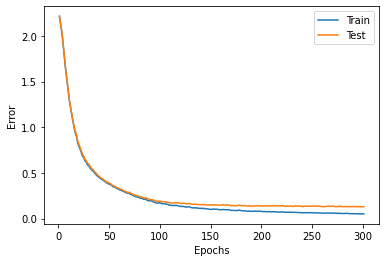

In [11]:
plt.plot(range(1, len(error_record_train) + 1), error_record_train, label="Train")
plt.plot(range(1, len(error_record_test) + 1), error_record_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

